In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-23 11:41:05.579981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 11:41:05.795203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 11:41:05.884458: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-23 11:41:06.580973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Note: Use conda tf-gpu environment. Copy of exp6 with more data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

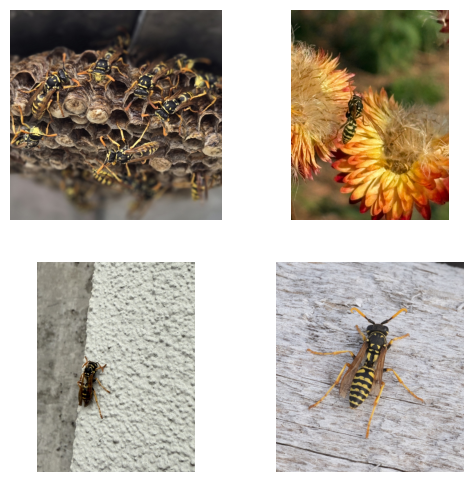

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 16

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 26030 images belonging to 127 classes.
Found 6477 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)


#for layer in base_model.layers[:-10]:
#    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.2))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(127, activation='softmax'))



2025-10-23 11:41:11.158501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2025-10-23 11:41:11.160248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2025-10-23 11:41:11.160261: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-10-23 11:41:11.160793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libra

In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 12,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

Epoch 1/30
1627/1627 [==============================] - ETA: 0s - loss: 3.0523 - accuracy: 0.2654

/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 1: val_average_precision = 0.3980
1627/1627 [==============================] - 1131s 692ms/step - loss: 3.0523 - accuracy: 0.2654 - val_loss: 2.3885 - val_accuracy: 0.3920 - val_average_precision: 0.3980 - lr: 1.0000e-04
Epoch 2/30
1627/1627 [==============================] - ETA: 0s - loss: 1.7911 - accuracy: 0.5034

/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 2: val_average_precision = 0.5002
1627/1627 [==============================] - 1114s 685ms/step - loss: 1.7911 - accuracy: 0.5034 - val_loss: 1.9172 - val_accuracy: 0.4904 - val_average_precision: 0.5002 - lr: 1.0000e-04
Epoch 3/30
1627/1627 [==============================] - ETA: 0s - loss: 1.2805 - accuracy: 0.6285

/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 3: val_average_precision = 0.5439
1627/1627 [==============================] - 1116s 686ms/step - loss: 1.2805 - accuracy: 0.6285 - val_loss: 1.7553 - val_accuracy: 0.5353 - val_average_precision: 0.5439 - lr: 1.0000e-04
Epoch 4/30
1627/1627 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.7085
Epoch 4: val_average_precision = 0.5229
1627/1627 [==============================] - 1111s 683ms/step - loss: 0.9641 - accuracy: 0.7085 - val_loss: 1.8998 - val_accuracy: 0.5256 - val_average_precision: 0.5229 - lr: 1.0000e-04


/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch 5/30
1627/1627 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.7727
Epoch 5: val_average_precision = 0.5474
1627/1627 [==============================] - 1113s 684ms/step - loss: 0.7315 - accuracy: 0.7727 - val_loss: 1.8950 - val_accuracy: 0.5487 - val_average_precision: 0.5474 - lr: 1.0000e-04


/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch 6/30
1627/1627 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.8221
Epoch 6: val_average_precision = 0.5418
1627/1627 [==============================] - 1117s 687ms/step - loss: 0.5683 - accuracy: 0.8221 - val_loss: 1.9022 - val_accuracy: 0.5317 - val_average_precision: 0.5418 - lr: 1.0000e-04


/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch 7/30
1627/1627 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8572
Epoch 7: val_average_precision = 0.5142
1627/1627 [==============================] - 1112s 683ms/step - loss: 0.4571 - accuracy: 0.8572 - val_loss: 2.3381 - val_accuracy: 0.5084 - val_average_precision: 0.5142 - lr: 1.0000e-04
Epoch 8/30


/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1627/1627 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8826
Epoch 8: val_average_precision = 0.5412
1627/1627 [==============================] - 1107s 680ms/step - loss: 0.3763 - accuracy: 0.8826 - val_loss: 2.1065 - val_accuracy: 0.5495 - val_average_precision: 0.5412 - lr: 1.0000e-04
Epoch 9/30


/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/pipeline_gui_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


 648/1627 [==========>...................] - ETA: 8:41 - loss: 0.2957 - accuracy: 0.9065

KeyboardInterrupt: 

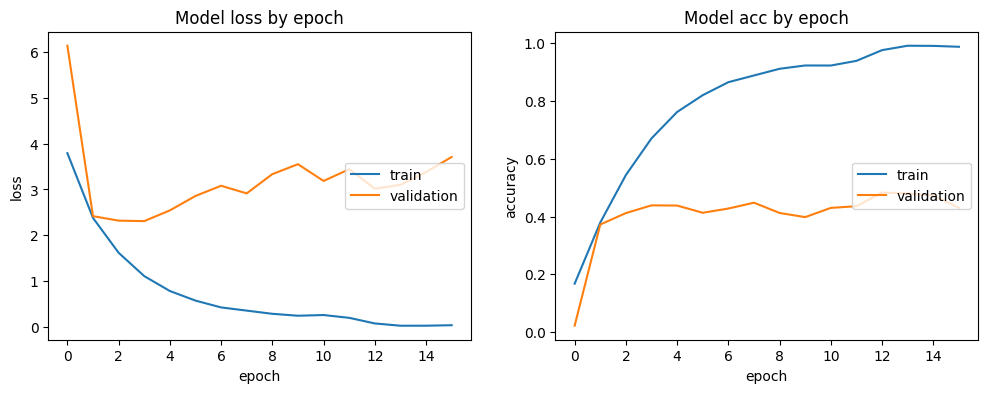

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
model.save('../models/model_127_species_exp8.h5')